# Xsens Time & Frequency Analysis

Goal: Read `.txt` file, construct `AbsoluteTime` from UTC columns, and determine:
1. **Start Time**
2. **Acquisition Frequency** (for accelerometers)
3. **Filter Acc_Z** (Low-Pass Butterworth) - *using Theoretical Fs = 400Hz*
4. **Spectral Analysis (FFT)** - *Check for engine vibrations*
5. **Plot Acc_Z & Trajectory**

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

Analyzing file: ../Moto_Chicane_mouille_80_P1.txt
Columns found: ['PacketCounter', 'SampleTimeFine', 'Year', 'Month', 'Day', 'Second', 'UTC_Nano', 'UTC_Year', 'UTC_Month', 'UTC_Day', 'UTC_Hour', 'UTC_Minute', 'UTC_Second', 'UTC_Valid', 'Acc_X', 'Acc_Y', 'Acc_Z', 'FreeAcc_E', 'FreeAcc_N', 'FreeAcc_U', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Roll', 'Pitch', 'Yaw', 'Latitude', 'Longitude', 'Altitude', 'Vel_E', 'Vel_N', 'Vel_U']

Start Time (UTC): 2025-11-06 14:58:11.718675648
Average Time Delta (dt): 0.002451 s
Calculated Frequency (Fs): 408.00 Hz
Using Theoretical Frequency (Fs): 400.00 Hz for filtering
Min dt: -0.161460 s
Max dt: 0.163945 s
Calculated Fs vs Theoretical 400Hz error: 8.00 Hz
Applied Low-Pass Butterworth Filter (fc=20Hz, order=4) to Acc_Z using Fs=400.0Hz
Filtered Min: 0.3865370719865549, Max: 19.51401334347096


C:\Users\es-sabar\AppData\Local\Temp\ipykernel_21648\3211715731.py:67: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  acc_z_clean = df['Acc_Z'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


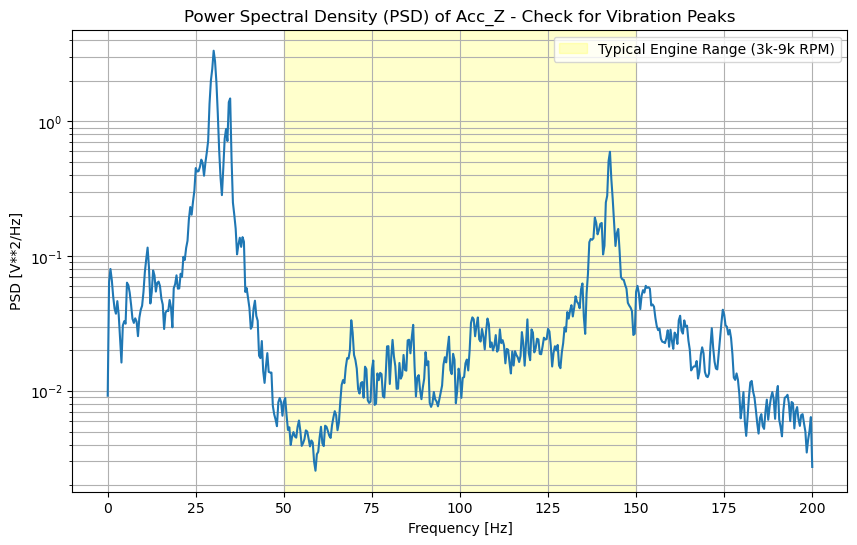

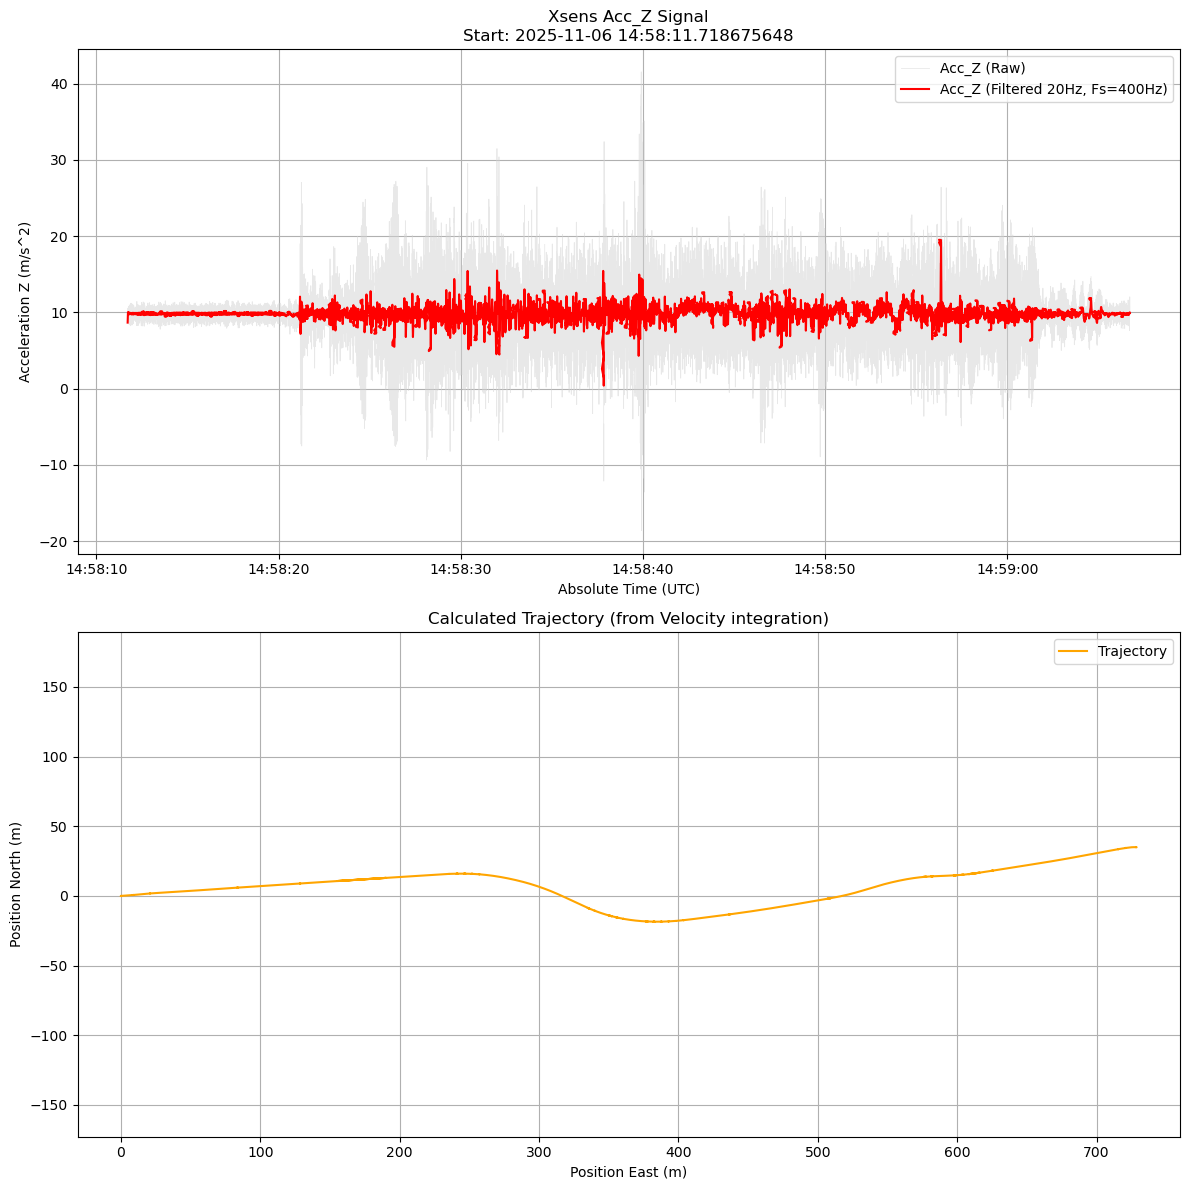

In [10]:
speed = 80
passage = 'P1'
file_path = f'../Moto_Chicane_mouille_{speed}_{passage}.txt'
print(f"Analyzing file: {file_path}")

# 1. Read Data
try:
    # Skip header lines (usually 12 for Xsens export)
    df = pd.read_csv(file_path, sep='\t', skiprows=12)
    
    # Clean column names (remove whitespace)
    df.columns = df.columns.str.strip()
    
    print("Columns found:", df.columns.tolist())
    
    # 2. Construct Absolute Time from UTC
    # Columns: UTC_Year, UTC_Month, UTC_Day, UTC_Hour, UTC_Minute, UTC_Second, UTC_Nano
    req_cols = ['UTC_Year', 'UTC_Month', 'UTC_Day', 'UTC_Hour', 'UTC_Minute', 'UTC_Second', 'UTC_Nano']
    
    if all(col in df.columns for col in req_cols):
        # Drop rows with NaNs in time columns if any
        df = df.dropna(subset=req_cols)
        
        # Standard DateTime (down to seconds)
        time_coarse = pd.to_datetime(df[['UTC_Year', 'UTC_Month', 'UTC_Day', 'UTC_Hour', 'UTC_Minute', 'UTC_Second']].astype(int).rename(columns={
            'UTC_Year': 'year', 'UTC_Month': 'month', 'UTC_Day': 'day',
            'UTC_Hour': 'hour', 'UTC_Minute': 'minute', 'UTC_Second': 'second'
        }))
        
        # Add Nanoseconds
        df['AbsoluteTime'] = time_coarse + pd.to_timedelta(df['UTC_Nano'], unit='ns')
        
        # 3. Calculate Start Time
        start_time = df['AbsoluteTime'].iloc[0]
        print(f"\nStart Time (UTC): {start_time}")
        
        # 4. Calculate Frequency
        # Calculate differences between consecutive samples in seconds
        time_diffs = df['AbsoluteTime'].diff().dt.total_seconds()
        
        # Mean dt (excluding the first NaN)
        mean_dt = time_diffs.mean()
        # Replace NaN in time_diffs with mean_dt for integration
        dt_series = time_diffs.fillna(mean_dt)
        
        # Frequency Analysis
        if mean_dt > 0:
            calc_freq = 1.0 / mean_dt
            print(f"Average Time Delta (dt): {mean_dt:.6f} s")
            print(f"Calculated Frequency (Fs): {calc_freq:.2f} Hz")
        else:
            calc_freq = 0
            print("Error: Mean time difference is 0 or invalid.")
            
        # Force Theoretical Frequency for Filter
        fs_theoretical = 400.0
        print(f"Using Theoretical Frequency (Fs): {fs_theoretical:.2f} Hz for filtering")

        # Check consistency/Jitter
        print(f"Min dt: {time_diffs.min():.6f} s")
        print(f"Max dt: {time_diffs.max():.6f} s")
        print(f"Calculated Fs vs Theoretical 400Hz error: {abs(calc_freq - 400):.2f} Hz")
        
        # 5. Filter Acc_Z (Butterworth Low-Pass)
        if 'Acc_Z' in df.columns:
            # IMPORTANT: Clean data before filtering.
            acc_z_clean = df['Acc_Z'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
            
            # Filter parameters
            fc = 20 # Cut-off frequency (Hz) - Updated to 30Hz as per experimentation
            order = 4 # Filter order
            
            # Use theoretical sampling rate for filter design
            w = fc / (fs_theoretical / 2) # Normalized frequency
            
            if w < 1:
                b, a = signal.butter(order, w, 'low')
                # Apply filter to cleaned data
                df['Acc_Z_Filt'] = signal.filtfilt(b, a, acc_z_clean)
                print(f"Applied Low-Pass Butterworth Filter (fc={fc}Hz, order={order}) to Acc_Z using Fs={fs_theoretical}Hz")
                
                # Verify data range
                print(f"Filtered Min: {df['Acc_Z_Filt'].min()}, Max: {df['Acc_Z_Filt'].max()}")
            else:
                print(f"Error: Cut-off freq {fc} is too high for sampling rate {fs_theoretical}")
        else:
            print("Skipping filter: Acc_Z not found")

        # 6. Trajectory Calculation (Integration of Velocity)
        # Use Vel_E and Vel_N if available
        if 'Vel_E' in df.columns and 'Vel_N' in df.columns:
            # Clean velocity data
            vel_e_clean = df['Vel_E'].interpolate().fillna(0)
            vel_n_clean = df['Vel_N'].interpolate().fillna(0)
            
            # Cumulative Sum of Velocity * dt = Position
            # Use calculated dt from timestamps for accurate integration
            df['Pos_E'] = (vel_e_clean * dt_series).cumsum()
            df['Pos_N'] = (vel_n_clean * dt_series).cumsum()
            has_traj = True
        else:
            print("Velocity columns (Vel_E, Vel_N) not found. Skipping trajectory.")
            has_traj = False
        
        # 7. Spectral Analysis (PSD)
        # Compute PSD to check for engine vibrations
        if 'Acc_Z' in df.columns:
            f, Pxx_den = signal.welch(acc_z_clean, fs=fs_theoretical, nperseg=1024)
            
            plt.figure(figsize=(10, 6))
            plt.semilogy(f, Pxx_den)
            plt.title('Power Spectral Density (PSD) of Acc_Z - Check for Vibration Peaks')
            plt.xlabel('Frequency [Hz]')
            plt.ylabel('PSD [V**2/Hz]')
            plt.grid(True, which='both')
            # Highlight expected engine freq range (e.g. 50-200Hz)
            plt.axvspan(50, 150, color='yellow', alpha=0.2, label='Typical Engine Range (3k-9k RPM)')
            plt.legend()
            plt.show()
            
        # 8. Plotting
        fig, axes = plt.subplots(2, 1, figsize=(12, 12))
        
        # Subplot 1: Acc_Z (Raw vs Filtered)
        if 'Acc_Z' in df.columns:
            # Plot Raw
            axes[0].plot(df['AbsoluteTime'], df['Acc_Z'], label='Acc_Z (Raw)', linewidth=0.6, alpha=0.5, color='lightgray')
            # Plot Filtered
            if 'Acc_Z_Filt' in df.columns:
                axes[0].plot(df['AbsoluteTime'], df['Acc_Z_Filt'], label=f'Acc_Z (Filtered {fc}Hz, Fs={int(fs_theoretical)}Hz)', linewidth=1.5, color='red')
            axes[0].set_xlabel('Absolute Time (UTC)')
            axes[0].set_ylabel('Acceleration Z (m/s^2)')
            axes[0].set_title(f'Xsens Acc_Z Signal\nStart: {start_time}')
            axes[0].legend()
            axes[0].grid(True)
        
        # Subplot 2: Trajectory
        if has_traj:
            axes[1].plot(df['Pos_E'], df['Pos_N'], label='Trajectory', linewidth=1.5, color='orange')
            axes[1].set_xlabel('Position East (m)')
            axes[1].set_ylabel('Position North (m)')
            axes[1].set_title('Calculated Trajectory (from Velocity integration)')
            axes[1].axis('equal') # Important for trajectory
            axes[1].grid(True)
            axes[1].legend()
        else:
            axes[1].text(0.5, 0.5, 'No Velocity Data for Trajectory', ha='center')
            
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"Error: Missing one or more UTC columns. Found: {df.columns}")

except Exception as e:
    print(f"An error occurred: {e}")

In [11]:
import sys
!{sys.executable} -m pip install nptdms
from nptdms import TdmsFile
import glob
import os
import numpy as np


In [12]:
# 1.b Load Matching TDMS Data
tdms_pattern = f'../*_{speed}*_{passage}*.tdms'
print(f'Looking for TDMS file with pattern: {tdms_pattern}')
tdms_files = glob.glob(tdms_pattern)

tdms_path = None
if tdms_files:
    tdms_path = tdms_files[0]
    print(f'Found TDMS file: {tdms_path}')
else:
    print('No matching TDMS file found. using fallback search...')
    # Fallback: try just speed
    tdms_files = glob.glob(f'../*_{speed}*.tdms')
    if tdms_files:
        tdms_path = tdms_files[0]
        print(f'Found TDMS file (fallback): {tdms_path}')


Looking for TDMS file with pattern: ../*_80*_P1*.tdms
No matching TDMS file found. using fallback search...
Found TDMS file (fallback): ..\Moto_Chicane_mouille_80.tdms


In [13]:
# 1.c Process TDMS Edges
tdms_acc = None
tdms_time = None
if tdms_path:
    try:
        tdms_file = TdmsFile(tdms_path)
        group = tdms_file.groups()[0]
        if 'Edges_RoueAR' in group:
            edges_ch = group['Edges_RoueAR']
            edges_data = edges_ch[:]
            print(f'Loaded {len(edges_data)} edges from TDMS.')
            # Basic Time construction for TDMS
            # Assuming constant sample rate properties usually available in waveform
            # For now, we will perform synchronization and more complex derivation later.
            # Just proving we can read it.
            print('TDMS properties:', edges_ch.properties)
        else:
            print('Edges_RoueAR channel not found in TDMS group.')
    except Exception as e:
        print(f'Error reading TDMS: {e}')


Loaded 44000 edges from TDMS.
TDMS properties: OrderedDict([('wf_start_time', np.datetime64('2025-11-06T14:45:33.807814')), ('wf_start_offset', 0.0), ('wf_increment', 0.0025), ('wf_samples', 1000), ('NI_ChannelName', 'Edges_RoueAR'), ('NI_UnitDescription', 'count'), ('unit_string', 'count')])


In [22]:

# 3. Derive Speed/Acceleration (Edge-Step Method)
# LOGIC FROM Merge_Data.ipynb (Adapted)

import numpy as np
from scipy import signal
import pandas as pd

derived_speed_mps = None
derived_acc_mps2 = None

# Ensure we have time and edges
if 'tdms_time' not in locals() or tdms_time is None:
    # Try to construct if missing (copy of logic just in case)
    if 'edges_ch' in locals():
        try:
            props = edges_ch.properties
            start_time = props.get('wf_start_time')
            increment = props.get('wf_increment')
            if start_time and increment:
                start_dt = pd.to_datetime(start_time).tz_localize(None)
                seconds = np.arange(len(edges_data)) * increment
                tdms_time = start_dt + pd.to_timedelta(seconds, unit='s')
        except:
            pass

if 'tdms_time' in locals() and tdms_time is not None and 'edges_data' in locals():
    try:
        # Parameters
        WHEEL_DIA_INCH = 17.0 # User preference (was 18.0 in old code)
        EDGES_PER_REV = 48.0
        STEP_EDGES =25
        
        wheel_circum_m = WHEEL_DIA_INCH * 0.0254 * np.pi
        meters_per_edge = wheel_circum_m / EDGES_PER_REV
        
        # Create DataFrame for derivation
        df_t = pd.DataFrame({'Edges': edges_data, 'Time': tdms_time})
        df_t['Time_ns'] = df_t['Time'].astype(np.int64)
        
        # 1. Unique edges
        df_unique = df_t.drop_duplicates(subset=['Edges'], keep='first')
        
        if len(df_unique) > 100:
            u_counts = df_unique['Edges'].values
            u_times_ns = df_unique['Time_ns'].values
            
            # 2. Grid of edges
            min_edge = u_counts.min()
            max_edge = u_counts.max()
            edge_grid = np.arange(np.ceil(min_edge/STEP_EDGES)*STEP_EDGES, max_edge, STEP_EDGES)
            
            # 3. Interpolate Time
            t_grid_ns = np.interp(edge_grid, u_counts, u_times_ns)
            
            # 4. Calc Speed
            dt_grid_s = np.diff(t_grid_ns) * 1e-9
            # Avoid divide by zero
            dt_grid_s[dt_grid_s == 0] = 1e-9
            
            speed_grid_edges_s = STEP_EDGES / dt_grid_s
            speed_grid_mps = speed_grid_edges_s * meters_per_edge
            
            # Map back to full time
            t_mid_ns = (t_grid_ns[:-1] + t_grid_ns[1:]) / 2
            
            full_time_ns = df_t['Time_ns'].values
            derived_speed_mps = np.interp(full_time_ns, t_mid_ns, speed_grid_mps, left=0, right=0)
            
            # Calc Accel
            fs = 1.0 / (pd.to_timedelta(increment, unit='s').total_seconds() if 'increment' in locals() else 0.0025)
            if 'increment' in locals() and increment: fs = 1.0/increment
            
            acc_raw = np.diff(derived_speed_mps, prepend=derived_speed_mps[0]) * fs
            
            # Filter
            b, a = signal.butter(2, 5, fs=fs, btype='low')
            derived_acc_mps2 = signal.filtfilt(b, a, acc_raw)
            
            print(f'Derivation Complete. Mean Speed: {np.mean(derived_speed_mps):.2f} m/s')
        else:
            print('Not enough unique edges for derivation')
    except Exception as e:
        print(f'Derivation Error: {e}')
else:
    print("Cannot derive: Missing 'tdms_time' or 'edges_data'")



Derivation Complete. Mean Speed: 9.24 m/s


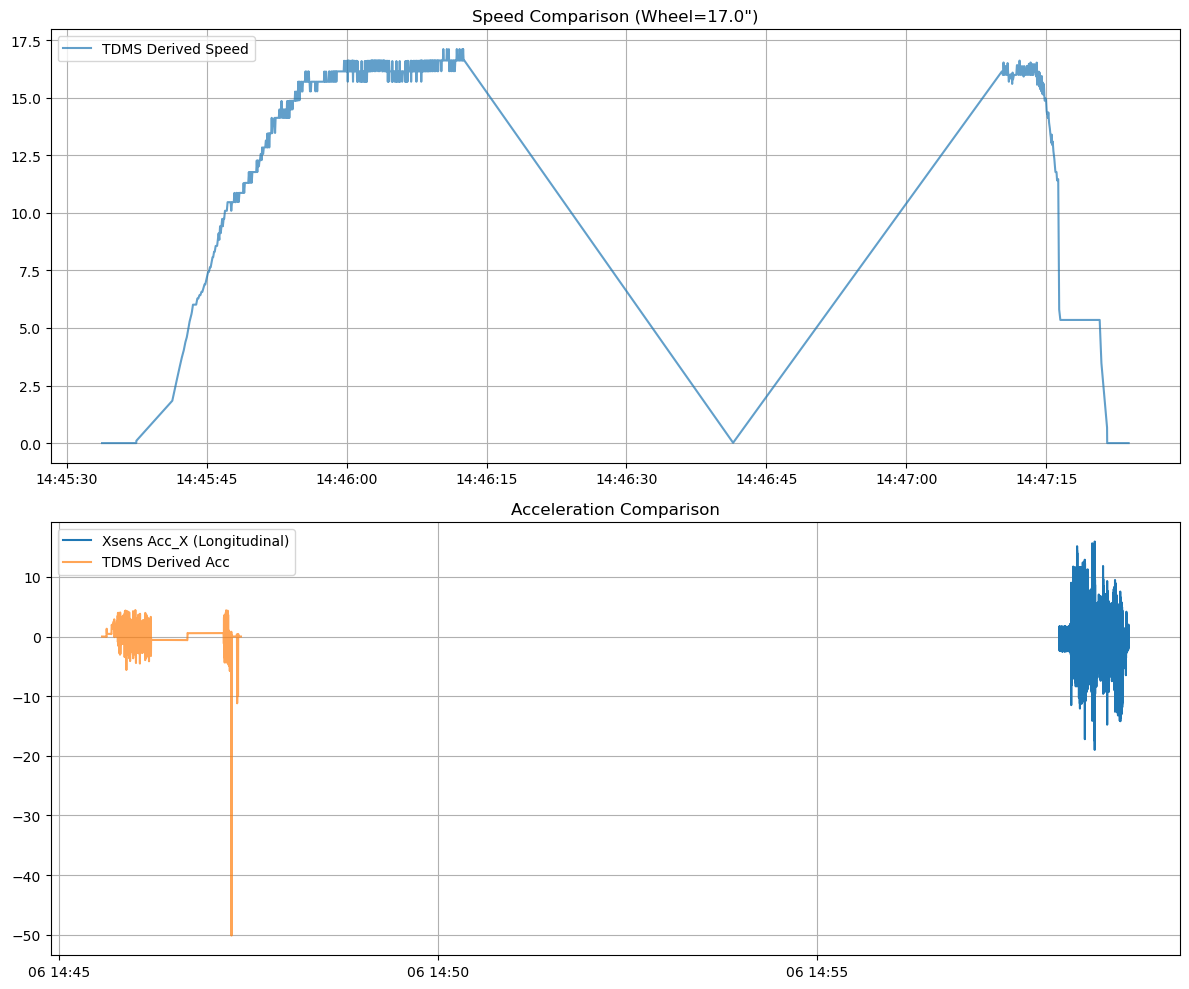

In [23]:

# 4. Visualization / Consistency Check
import matplotlib.pyplot as plt

if 'derived_speed_mps' in locals() and derived_speed_mps is not None:
    plt.figure(figsize=(12, 10))
    
    # Subplot 1: Speed
    plt.subplot(2,1,1)
    
    # Xsens Speed
    # Try different potential column names
    speed_col = None
    for c in ['GPS_Speed', 'Velocity', 'Speed']:
        if c in df.columns:
            speed_col = c
            break
            
    if speed_col:
        plt.plot(df['AbsoluteTime'], df[speed_col], label=f'Xsens {speed_col}')
    
    # TDMS Speed
    plt.plot(tdms_time, derived_speed_mps, label='TDMS Derived Speed', alpha=0.7)
    plt.title(f'Speed Comparison (Wheel={WHEEL_DIA_INCH}")')
    plt.legend()
    plt.grid(True)
    
    # Subplot 2: Acc
    plt.subplot(2,1,2)
    # Xsens Acc
    if 'Acc_X' in df.columns:
        plt.plot(df['AbsoluteTime'], df['Acc_X'], label='Xsens Acc_X (Longitudinal)')
    
    # TDMS Acc
    plt.plot(tdms_time, derived_acc_mps2, label='TDMS Derived Acc', alpha=0.7)
    plt.title('Acceleration Comparison')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("No derived speed to plot.")

